In [1]:
import importlib.util
if importlib.util.find_spec('pyflamegpu') is None:
    import sys
    !{sys.executable} -m pip install -I https://github.com/FLAMEGPU/FLAMEGPU2/releases/download/v2.0.0-rc/pyflamegpu-2.0.0rc0+cuda112-cp39-cp39-linux_x86_64.whl # type: ignore

# Import pyflamegpu and some other libraries we will use in the tutorial
import pyflamegpu
import sys, random, math
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.8/168.8 MB 5.5 MB/s eta 0:00:00


In [12]:
import matplotlib.pyplot as plt

import numpy as np

In [24]:
import pyflamegpu as fgpu


In [6]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [7]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [18]:
def distances_from(n, i, j):
    """Computes an array of distances.
    
    n: size of the array
    i, j: coordinates to find distance from
    
    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [13]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [14]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [70]:
from Cell2D import Cell2D, draw_array

class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        self.fgpu_context = fgpu.ModelDescription("Sugarscape_GPU")

        self.initialize_flamegpu()


    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)
        
        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        assert(num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    # def step(self):
    #     """Executes one time step."""
    #     replace = self.params.get('replace', False)
        
    #     # loop through the agents in random order
    #     random_order = np.random.permutation(self.agents)
    #     for agent in random_order:
            
    #         # mark the current cell unoccupied
    #         self.occupied.remove(agent.loc)
            
    #         # execute one step
    #         agent.step(self)

    #         # if the agent is dead, remove from the list
    #         if agent.is_starving() or agent.is_old():
    #             self.agents.remove(agent)
    #             if replace:
    #                 self.add_agent()
    #         else:
    #             # otherwise mark its cell occupied
    #             self.occupied.add(agent.loc)

    #     # update the time series
    #     self.agent_count_seq.append(len(self.agents))
        
    #     # grow back some sugar
    #     self.grow()
    #     return len(self.agents)
    def step(self):
      replace = self.params.get('replace', False)
      
      # Execute the FLAMEGPU simulation step
      self.fgpu_sim.simulate()
      
      # Update the agents
      self.agents = []
      self.occupied = set()
      for i in range(self.fgpu_sim.getNumAgents("Agent")):
          agent = self.fgpu_sim.getAgent("Agent", i)
          
          # Get the agent's properties
          x = agent.getVariableInt("x")
          y = agent.getVariableInt("y")
          loc = (x, y)
          age = agent.getVariableInt("age")
          vision = agent.getVariableInt("vision")
          metabolism = agent.getVariableFloat("metabolism")
          lifespan = agent.getVariableFloat("lifespan")
          sugar = agent.getVariableFloat("sugar")
          
          # Create a new Agent instance
          new_agent = Agent(loc, self.params)
          new_agent.age = age
          new_agent.vision = vision
          new_agent.metabolism = metabolism
          new_agent.lifespan = lifespan
          new_agent.sugar = sugar
          
          # Check if the agent is dead
          if new_agent.is_starving() or new_agent.is_old():
              if replace:
                  self.add_agent()
          else:
              self.agents.append(new_agent)
              self.occupied.add(loc)

      # Update the time series
      self.agent_count_seq.append(len(self.agents))
      
      # Grow back some sugar
      self.grow()
      return len(self.agents)
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        
        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys
    def initialize_flamegpu(self):
        # Create environment description
        env = self.fgpu_context.Environment()

        # Add environment property for sugar capacity array
        sugar_capacity = self.make_capacity()
        flat_capacity = np.array(sugar_capacity).flatten().tolist()
        env.newPropertyArrayUInt32("sugar_capacity", flat_capacity)

        # Add environment property for sugar array
        env.newPropertyArrayFloat("sugar", self.n * self.n)

        # Initialize sugar array using self.array
        sugar_array = self.array
        for x in range(self.n):
            for y in range(self.n):
                index = x * self.n + y
                env.setPropertyArrayFloatAt("sugar", index, sugar_array[x][y])

        # Create agent description
        agent_desc = fgpu.AgentDescription("Agent")

        # Add agent variables
        agent_desc.newVariableInt("x")
        agent_desc.newVariableInt("y")
        agent_desc.newVariableInt("age")
        agent_desc.newVariableInt("vision")
        agent_desc.newVariableFloat("metabolism")
        agent_desc.newVariableFloat("lifespan")
        agent_desc.newVariableFloat("sugar")

        # Register agent description
        self.fgpu_context.addAgent(agent_desc)

        # Define agent functions
        agent_function_look_and_move = fgpu.AgentFunctionDescription(
            "look_and_move",
            Agent.agent_function_look_and_move
        )

        agent_function_harvest = fgpu.AgentFunctionDescription(
            "harvest",
            Agent.agent_function_harvest
        )
        agent_function_metabolism_and_aging = fgpu.AgentFunctionDescription(
            "metabolism_and_aging",
            Agent.agent_function_metabolism_and_aging
        )

        # Register agent functions
        agent_desc.addAgentFunction(agent_function_look_and_move)
        agent_desc.addAgentFunction(agent_function_harvest)
        agent_desc.addAgentFunction(agent_function_metabolism_and_aging)

        # Create agent population
        agent_population = fgpu.AgentVector(agent_desc, len(self.agents))

        # Initialize agent population
        for i, agent in enumerate(self.agents):
            instance = agent_population[i]
            instance.setVariableInt("x", agent.loc[0])
            instance.setVariableInt("y", agent.loc[1])
            instance.setVariableInt("age", agent.age)
            instance.setVariableInt("vision", agent.vision)
            instance.setVariableFloat("metabolism", agent.metabolism)
            instance.setVariableFloat("lifespan", agent.lifespan)
            instance.setVariableFloat("sugar", agent.sugar)

        # Set initial population state
        self.fgpu_context.addInitialPopulationData(agent_population)

        # Create the simulation
        self.fgpu_sim = fgpu.CUDASimulation(self.fgpu_context)

        # Configure the simulation
        self.fgpu_sim.addAgentFunction("Agent", "look_and_move")
        self.fgpu_sim.addAgentFunction("Agent", "harvest")
        self.fgpu_sim.addAgentFunction("Agent", "metabolism_and_aging")


In [71]:

class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0
        self.vision = params.get('vision', 6)
        self.metabolism = params.get('metabolism', 1)
        self.lifespan = params.get('lifespan', 100)
        self.sugar = params.get('initial_sugar', 5)
        self.variables = {
        "loc": self.loc,
        "age": self.age,
        "vision": self.vision,
        "metabolism": self.metabolism,
        "lifespan": self.lifespan,
        "sugar": self.sugar,}

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

    @staticmethod
    def agent_function_metabolism_and_aging(agent, message_board, rng):
        # Subtract metabolism from sugar
        sugar = agent.getVariableFloat("sugar")
        metabolism = agent.getVariableFloat("metabolism")
        sugar -= metabolism

        # Increment age
        age = agent.getVariableInt("age")
        age += 1

        # Update agent variables
        agent.setVariableFloat("sugar", sugar)
        agent.setVariableInt("age", age)
        return fgpu.CONTINUE
    @staticmethod
    def agent_function_look_and_move(agent, message_board, rng):
      x = agent.getVariableInt("x")
      y = agent.getVariableInt("y")
      vision = agent.getVariableInt("vision")

      # Get the environment sugar_capacity property
      sugar_capacity = agent.environment.getPropertyUInt2D("sugar_capacity")

      max_sugar = -1
      max_sugar_x = x
      max_sugar_y = y

      # Iterate over the visible cells within agent's vision
      for i in range(-vision, vision + 1):
          for j in range(-vision, vision + 1):
              # Calculate the new coordinates
              new_x = (x + i) % agent.environment.width
              new_y = (y + j) % agent.environment.height

              # Get the sugar at the new location
              sugar = sugar_capacity[new_x][new_y]

              # Update the maximum sugar and location if necessary
              if sugar > max_sugar:
                  max_sugar = sugar
                  max_sugar_x = new_x
                  max_sugar_y = new_y

      # Update agent's position
      agent.setVariableInt("x", max_sugar_x)
      agent.setVariableInt("y", max_sugar_y)

      return fgpu.CONTINUE
    @staticmethod
    def agent_function_harvest(agent, message_board, rng):
        x = agent.getVariableInt("x")
        y = agent.getVariableInt("y")

        # Get the environment sugar_capacity and sugar properties
        sugar_capacity = agent.environment.getPropertyUInt2D("sugar_capacity")
        sugar = agent.environment.getPropertyFloat2D("sugar")

        # Get the sugar at the agent's location
        sugar_at_location = sugar[x][y]

        # Add the harvested sugar to the agent's sugar
        agent_sugar = agent.getVariableFloat("sugar")
        agent_sugar += sugar_at_location

        # Set the sugar at the agent's location to zero
        sugar[x][y] = 0

        # Update the agent's sugar variable
        agent.setVariableFloat("sugar", agent_sugar)

        return fgpu.CONTINUE
    @staticmethod
    def agent_function_step(agent, message_board, rng):
        # Call agent_function_look_and_move
        Agent.agent_function_look_and_move(agent, message_board, rng)

        # Call agent_function_harvest
        Agent.agent_function_harvest(agent, message_board, rng)

        # Call agent_function_metabolism_and_aging
        Agent.agent_function_metabolism_and_aging(agent, message_board, rng)

        return fgpu.CONTINUE



In [72]:
env = Sugarscape(50)

TypeError: ignored

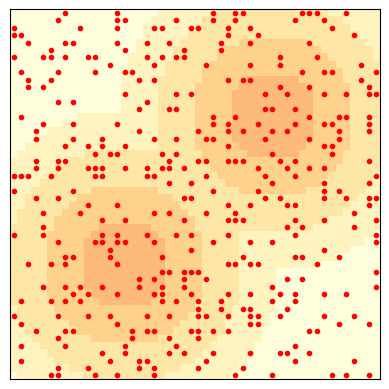

AttributeError: ignored

In [26]:
env.animate(frames=50)
